#Student Name: Pranav Mohan
#ECE 595 Machine Learning II
#Project 3: GAN - Student Code

In [1]:
#Import necessary packages
import numpy as np
import keras
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, InputLayer, Input, LeakyReLU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.datasets import mnist
# from keras.layers.advanced_activations import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from random import random 
from functools import partial
print(tf.__version__)
import sys

Using TensorFlow backend.


2.3.0


2021-10-31 10:42:19.797295: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


#Part 1: Implementing the GAN

In [2]:
#Load MNIST data and normalize to [-1, 1]
(data_train, _), (data_test, _) = mnist.load_data()
data_train = 2.*(data_train)/255.-1; print(tf.shape(data_train))
data_test = 2.*(data_test)/255.-1; print(tf.shape(data_test))

tf.Tensor([60000    28    28], shape=(3,), dtype=int32)
tf.Tensor([10000    28    28], shape=(3,), dtype=int32)


2021-10-31 10:42:23.721583: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2021-10-31 10:42:23.742602: E tensorflow/stream_executor/cuda/cuda_driver.cc:314] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-10-31 10:42:23.742660: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (scholar-fe03.rcac.purdue.edu): /proc/driver/nvidia/version does not exist
2021-10-31 10:42:23.743961: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-31 10:42:23.762482: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2596820000 Hz
2021-10-31 10:42:23.7

In [3]:
print(tf.shape(data_train[:,1,1]))
random()
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
tf.test.is_gpu_available(
    cuda_only=False, min_cuda_compute_capability=None
)

tf.Tensor([60000], shape=(1,), dtype=int32)
2.3.0
Num GPUs Available:  0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


2021-10-31 08:37:37.307311: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x560f4d0a2b10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2021-10-31 08:37:37.307357: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla V100-PCIE-16GB, Compute Capability 7.0
2021-10-31 08:37:37.310479: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:d8:00.0 name: Tesla V100-PCIE-16GB computeCapability: 7.0
coreClock: 1.38GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2021-10-31 08:37:37.310537: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2021-10-31 08:37:37.310573: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2021-10-31 08:37:37.310592: I tensorflow/stream_executor/platform/default/dso_l

False

Epoch 10000[Discriminator loss: 0.357269, acc: 0.500000]  [GAN loss: 2.255425, acc: 0.000000]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


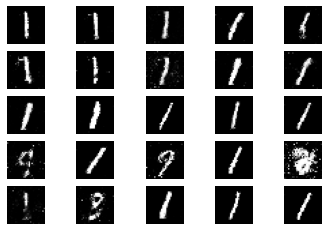

Epoch 20000[Discriminator loss: 0.441980, acc: 0.484375]  [GAN loss: 1.486876, acc: 0.109375]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


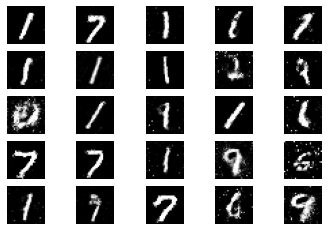

Epoch 30000[Discriminator loss: 0.432816, acc: 0.468750]  [GAN loss: 2.165834, acc: 0.031250]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


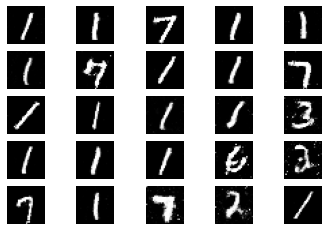

Epoch 40000[Discriminator loss: 0.442727, acc: 0.476562]  [GAN loss: 2.104522, acc: 0.062500]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


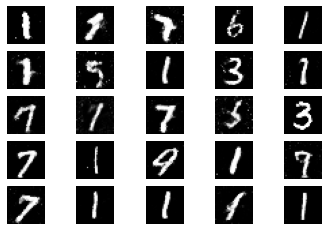

Epoch 50000[Discriminator loss: 0.415876, acc: 0.476562]  [GAN loss: 2.286961, acc: 0.000000]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


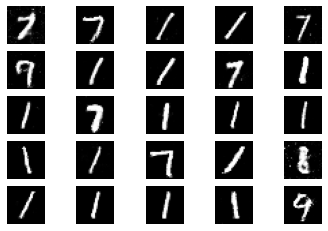

Epoch 60000[Discriminator loss: 0.449302, acc: 0.492188]  [GAN loss: 1.917461, acc: 0.093750]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


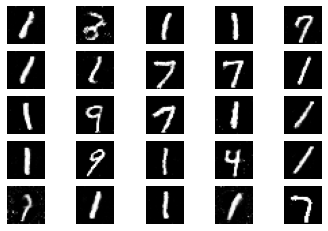

Epoch 70000[Discriminator loss: 0.352397, acc: 0.468750]  [GAN loss: 2.212548, acc: 0.078125]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


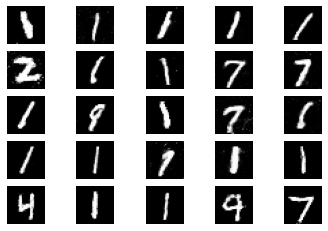

Epoch 80000[Discriminator loss: 0.376241, acc: 0.476562]  [GAN loss: 2.969797, acc: 0.015625]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


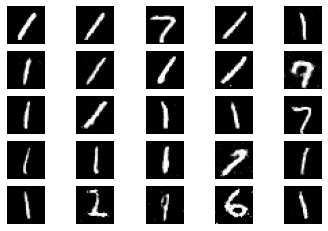

Epoch 90000[Discriminator loss: 0.357816, acc: 0.468750]  [GAN loss: 2.372096, acc: 0.062500]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


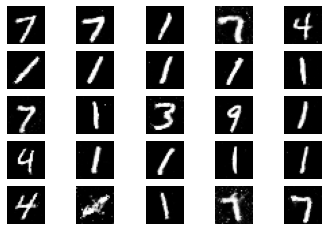

Epoch 100000[Discriminator loss: 0.344520, acc: 0.492188]  [GAN loss: 2.987166, acc: 0.000000]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


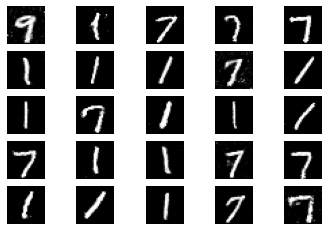

In [5]:
# The D-dimensional noise vector length
latent_dim = 100; data_dem=784;

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

def gan_optimizer():
    return Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Genrerator model
def create_generator(alpha=0.1):
    generator=Sequential(); # generator.add(InputLayer(input_shape=(latent_dim,)))
    generator.add(Dense(300,input_dim=latent_dim))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(600))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(data_dem,activation="tanh"))
    return generator

# Discriminator model
def create_discriminator(alpha=0.1):
    discriminator=Sequential(); 
    discriminator.add(Dense(1200,input_dim=data_dem))
    discriminator.add(LeakyReLU(alpha))
    #discriminator.add(Dropout(0.5))
    discriminator.add(Dense(600))
    discriminator.add(LeakyReLU(alpha))
    #discriminator.add(Dropout(0.5))
    discriminator.add(Dense(300))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dense(1,activation="sigmoid"))
    discriminator.compile(loss="bce",optimizer=dis_optimizer(),metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="bce",optimizer=gan_optimizer(),metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)
# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000; 
batch_size = 64;
sample_interval = 10000
# Array to save training history
training_meta_data2 = np.zeros([epochs, 4])
# Generate random noise as input

# Training the GAN
for e in range(1, epochs+1):
    sys.stdout.write("\rEpoch %i" % e)
    sys.stdout.flush()
    # Create noise 
    noise = np.random.normal(0,1 ,[batch_size,latent_dim]);#print(tf.shape(noise))
    # noise = tf.random.normal([1, 100])
    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise);

    # Get a random set of real MNIST images
    #real_images=np.zeros((batch_size,28,28))
    real_images = data_train[np.random.randint(0,data_train.shape[0],batch_size)]
    
    
    # Concatenate real and fake images into a single array (or batch)
    real_images_flat = real_images.reshape(-1,784)
    data = np.concatenate((real_images.reshape(-1,784),fake_images))
    
    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real = np.ones((batch_size,1))*0.9; labels_fake=np.zeros((batch_size,1)); 
    labels_discriminator=np.concatenate((labels_real,labels_fake)); #print(tf.shape(labels_discriminator))

    # Allow discriminator parameters to be updated
    discriminator.trainable=True;

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data,labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0,1,[batch_size,latent_dim]); #print(tf.shape(noise))

    # Keep discriminator weights constant while training generator
    labels_generator = np.ones((batch_size,1))
    discriminator.trainable=False;
    # generator.train_on_batch(noise,labels_generator)

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data2[e-1, 0] = d_loss[0]
    training_meta_data2[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data2[e-1, 2] = d_loss[1]
    training_meta_data2[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
#         print("Epoch %d" %e)
        log_mesg = "[Discriminator loss: %f, acc: %f]" % ( d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)
        print(tf.shape(gen_imgs))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

Epoch 10000[Discriminator loss: 0.384883, acc: 0.484375]  [GAN loss: 2.015355, acc: 0.046875]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


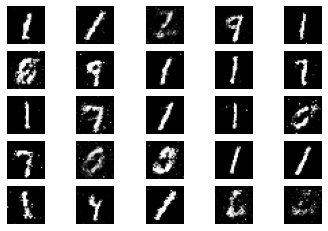

Epoch 20000[Discriminator loss: 0.506317, acc: 0.421875]  [GAN loss: 1.770773, acc: 0.046875]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


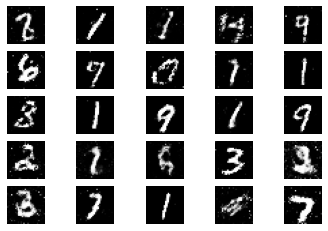

Epoch 30000[Discriminator loss: 0.556226, acc: 0.421875]  [GAN loss: 1.268012, acc: 0.187500]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


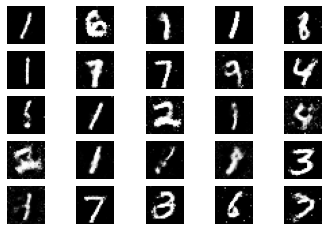

Epoch 40000[Discriminator loss: 0.585609, acc: 0.382812]  [GAN loss: 1.233718, acc: 0.218750]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


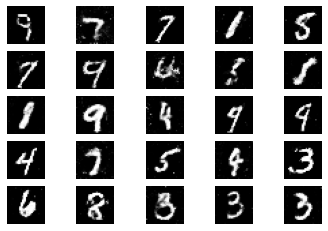

Epoch 50000[Discriminator loss: 0.621189, acc: 0.453125]  [GAN loss: 1.249656, acc: 0.171875]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


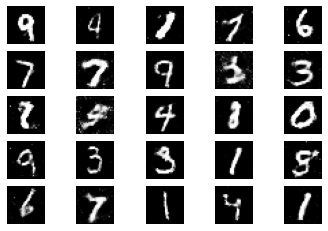

Epoch 60000[Discriminator loss: 0.523272, acc: 0.437500]  [GAN loss: 1.502334, acc: 0.109375]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


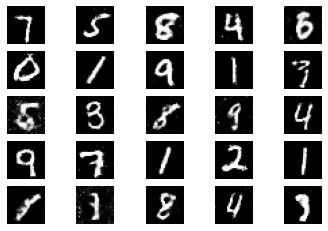

Epoch 70000[Discriminator loss: 0.564725, acc: 0.414062]  [GAN loss: 1.529664, acc: 0.125000]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


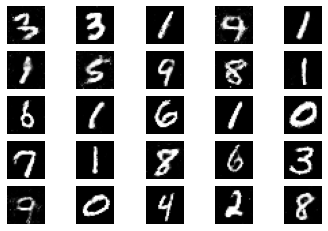

Epoch 80000[Discriminator loss: 0.589015, acc: 0.375000]  [GAN loss: 1.117129, acc: 0.203125]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


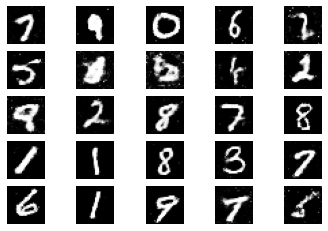

Epoch 90000[Discriminator loss: 0.541146, acc: 0.445312]  [GAN loss: 1.271949, acc: 0.218750]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


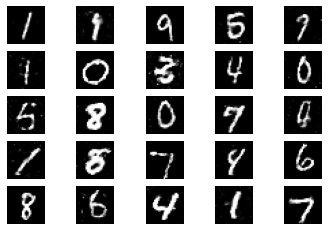

Epoch 100000[Discriminator loss: 0.582688, acc: 0.382812]  [GAN loss: 1.369255, acc: 0.062500]
tf.Tensor([ 64 784], shape=(2,), dtype=int32)


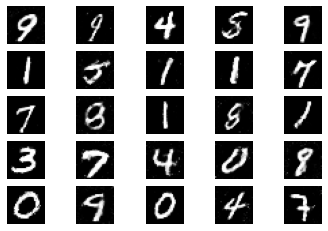

In [3]:
# The D-dimensional noise vector length
latent_dim = 100; data_dem=784;

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

def gan_optimizer():
    return Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Genrerator model
def create_generator(alpha=0.1):
    generator=Sequential(); # generator.add(InputLayer(input_shape=(latent_dim,)))
    generator.add(Dense(300,input_dim=latent_dim))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(600))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(data_dem,activation="tanh"))
    return generator

# Discriminator model
def create_discriminator(alpha=0.1, beta=0.3):
    discriminator=Sequential(); 
    discriminator.add(Dense(1200,input_dim=data_dem))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dropout(beta))
    discriminator.add(Dense(600))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dropout(beta))
    discriminator.add(Dense(300))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dense(1,activation="sigmoid"))
    discriminator.compile(loss="bce",optimizer=dis_optimizer(),metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="bce",optimizer=gan_optimizer(),metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000; 
batch_size = 64;
sample_interval = 10000
# Array to save training history
training_meta_data = np.zeros([epochs, 4])
# Generate random noise as input

# Training the GAN
for e in range(1, epochs+1):
    sys.stdout.write("\rEpoch %i" % e)
    sys.stdout.flush()
    # Create noise 
    noise = np.random.normal(0,1 ,[batch_size,latent_dim]);#print(tf.shape(noise))
    # noise = tf.random.normal([1, 100])
    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise);

    # Get a random set of real MNIST images
    #real_images=np.zeros((batch_size,28,28))
    real_images = data_train[np.random.randint(0,data_train.shape[0],batch_size)]
    
    
    # Concatenate real and fake images into a single array (or batch)
    real_images_flat = real_images.reshape(-1,784)
    data = np.concatenate((real_images.reshape(-1,784),fake_images))
    
    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real = np.ones((batch_size,1))*0.9; labels_fake=np.zeros((batch_size,1)); 
    labels_discriminator=np.concatenate((labels_real,labels_fake)); #print(tf.shape(labels_discriminator))

    # Allow discriminator parameters to be updated
    discriminator.trainable=True;

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data,labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0,1,[batch_size,latent_dim]); #print(tf.shape(noise))

    # Keep discriminator weights constant while training generator
    labels_generator = np.ones((batch_size,1))
    discriminator.trainable=False;
    # generator.train_on_batch(noise,labels_generator)

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data[e-1, 0] = d_loss[0]
    training_meta_data[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data[e-1, 2] = d_loss[1]
    training_meta_data[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
#         print("Epoch %d" %e)
        log_mesg = "[Discriminator loss: %f, acc: %f]" % ( d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)
        print(tf.shape(gen_imgs))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

Text(0.5, 0.98, 'GAN With Dropout')

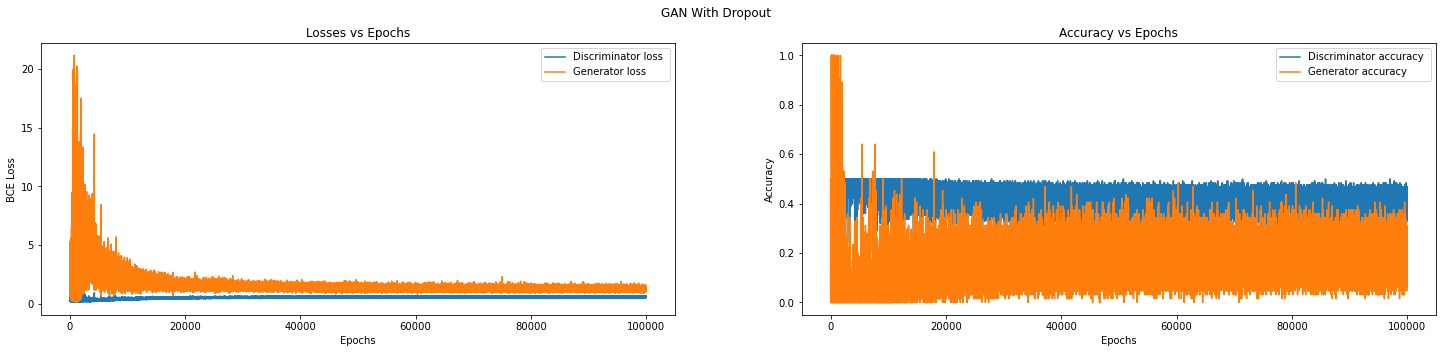

In [4]:
# Plot model loss vs epoch
plt.figure(figsize=(25,5))
plt.subplot(121)
plt.plot(training_meta_data[:,0]); plt.plot(training_meta_data[:,1]); plt.legend(['Discriminator loss ','Generator loss']);plt.xlabel("Epochs"); 
plt.title('Losses vs Epochs'); plt.ylabel('BCE Loss')
plt.subplot(122)
plt.plot(training_meta_data[:,2]); plt.plot(training_meta_data[:,3]); plt.legend(['Discriminator accuracy ','Generator accuracy']);plt.xlabel("Epochs"); 
plt.title('Accuracy vs Epochs'); plt.ylabel('Accuracy')
plt.suptitle('GAN With Dropout')

Text(0.5, 0.98, 'GAN Without Dropout')

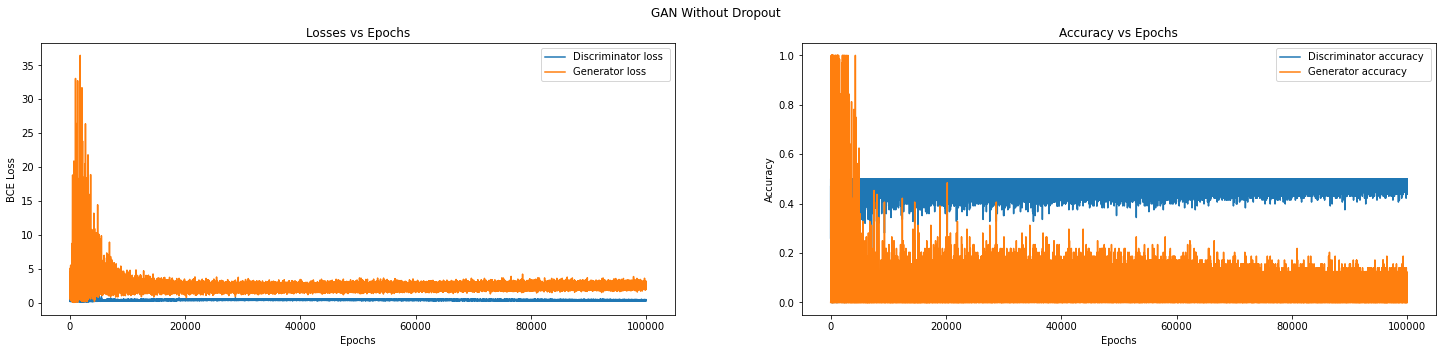

In [6]:
# Plot accuracy vs epoch
# Plot model loss vs epoch
plt.figure(figsize=(25,5))
plt.subplot(121)
plt.plot(training_meta_data2[:,0]); plt.plot(training_meta_data2[:,1]); plt.legend(['Discriminator loss ','Generator loss']);plt.xlabel("Epochs"); 
plt.title('Losses vs Epochs'); plt.ylabel('BCE Loss')
plt.subplot(122)
plt.plot(training_meta_data2[:,2]); plt.plot(training_meta_data2[:,3]); plt.legend(['Discriminator accuracy ','Generator accuracy']);plt.xlabel("Epochs"); 
plt.title('Accuracy vs Epochs'); plt.ylabel('Accuracy')
plt.suptitle('GAN Without Dropout')

Epoch 10000[Discriminator loss: 0.464943, acc: 0.468750]  [GAN loss: 1.975279, acc: 0.125000]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


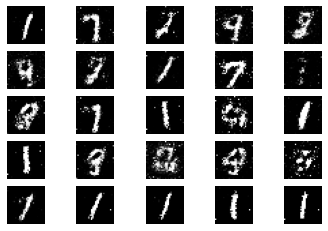

Epoch 20000[Discriminator loss: 0.650335, acc: 0.453125]  [GAN loss: 1.272569, acc: 0.125000]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


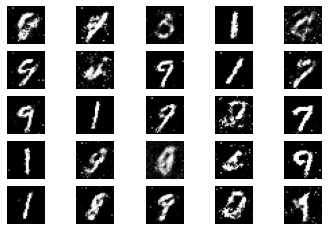

Epoch 30000[Discriminator loss: 0.538603, acc: 0.421875]  [GAN loss: 1.421668, acc: 0.187500]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


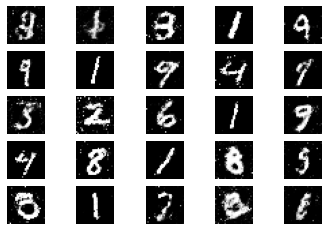

Epoch 40000[Discriminator loss: 0.624316, acc: 0.343750]  [GAN loss: 1.125758, acc: 0.218750]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


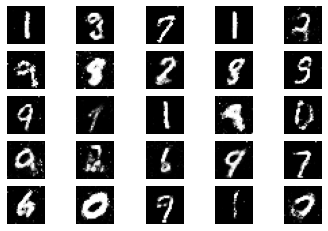

Epoch 50000[Discriminator loss: 0.556131, acc: 0.406250]  [GAN loss: 1.171785, acc: 0.156250]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


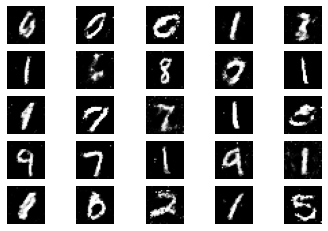

Epoch 60000[Discriminator loss: 0.529725, acc: 0.453125]  [GAN loss: 1.266065, acc: 0.156250]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


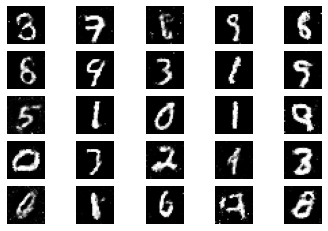

Epoch 70000[Discriminator loss: 0.594531, acc: 0.421875]  [GAN loss: 1.027242, acc: 0.250000]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


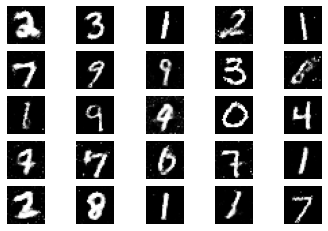

Epoch 80000[Discriminator loss: 0.590629, acc: 0.296875]  [GAN loss: 0.965573, acc: 0.250000]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


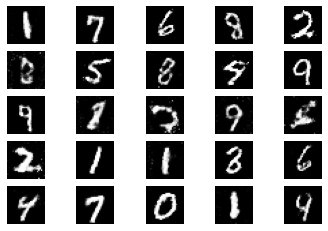

Epoch 90000[Discriminator loss: 0.548600, acc: 0.421875]  [GAN loss: 1.298047, acc: 0.218750]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


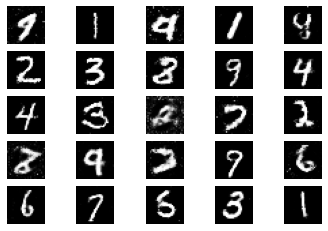

Epoch 100000[Discriminator loss: 0.562996, acc: 0.390625]  [GAN loss: 1.342279, acc: 0.156250]
tf.Tensor([ 32 784], shape=(2,), dtype=int32)


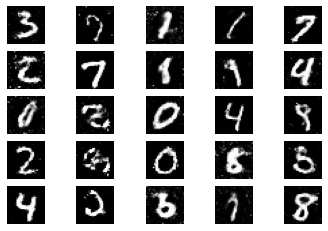

In [49]:
# The D-dimensional noise vector length
latent_dim = 100; data_dem=784;

# Optimizer for discriminator, which will have a higher learning rate than adversarial model
def dis_optimizer():
    return Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.999)

def gan_optimizer():
    return Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999)

# Genrerator model
def create_generator(alpha=0.1):
    generator=Sequential(); # generator.add(InputLayer(input_shape=(latent_dim,)))
    generator.add(Dense(300,input_dim=latent_dim))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(600))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(1200))
    generator.add(LeakyReLU(alpha))
    generator.add(Dense(data_dem,activation="tanh"))
    return generator

# Discriminator model
def create_discriminator(alpha=0.1, beta=0.3):
    discriminator=Sequential(); 
    discriminator.add(Dense(1200,input_dim=data_dem))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dropout(beta))
    discriminator.add(Dense(600))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dropout(beta))
    discriminator.add(Dense(300))
    discriminator.add(LeakyReLU(alpha))
    discriminator.add(Dense(1,activation="sigmoid"))
    discriminator.compile(loss="bce",optimizer=dis_optimizer(),metrics=['accuracy'])
    return discriminator

# Create adversarial model
def create_gan(discriminator, generator):
    discriminator.trainable = False
    gan_input = Input(shape=(latent_dim,))
    x = generator(gan_input)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss="bce",optimizer=gan_optimizer(),metrics=['accuracy'])
    return gan

# Creating GAN
generator = create_generator()
discriminator = create_discriminator()
gan = create_gan(discriminator, generator)

# Model and training parameters
#ASSIGN VALUES TO THE FOLLOWING VARIABLES
epochs = 100000; 
batch_size = 32;
sample_interval = 10000
# Array to save training history
training_meta_data3 = np.zeros([epochs, 4])
# Generate random noise as input

# Training the GAN
for e in range(1, epochs+1):
    sys.stdout.write("\rEpoch %i" % e)
    sys.stdout.flush()
    # Create noise 
    noise = np.random.normal(0,1 ,[batch_size,latent_dim]);#print(tf.shape(noise))
    # noise = tf.random.normal([1, 100])
    # Generate fake MNIST images from generated noise
    fake_images = generator.predict(noise);

    # Get a random set of real MNIST images
    #real_images=np.zeros((batch_size,28,28))
    real_images = data_train[np.random.randint(0,data_train.shape[0],batch_size)]
    
    
    # Concatenate real and fake images into a single array (or batch)
    real_images_flat = real_images.reshape(-1,784)
    data = np.concatenate((real_images.reshape(-1,784),fake_images))
    
    # Assign training labels (assign high probability, but not 1, to real images)
    labels_real = np.ones((batch_size,1))*0.9; labels_fake=np.zeros((batch_size,1)); 
    labels_discriminator=np.concatenate((labels_real,labels_fake)); #print(tf.shape(labels_discriminator))

    # Allow discriminator parameters to be updated
    discriminator.trainable=True;

    # Train discriminator on batch of real and fake images. Assign loss and accuracy to variable
    d_loss = discriminator.train_on_batch(data,labels_discriminator)

    # Train adversarial model and try to fool discriminator (with incorrect label) 
    # by generating a new batch of noise and assign them labels of real data
    noise = np.random.normal(0,1,[batch_size,latent_dim]); #print(tf.shape(noise))

    # Keep discriminator weights constant while training generator
    labels_generator = np.ones((batch_size,1))
    discriminator.trainable=False;
    # generator.train_on_batch(noise,labels_generator)

    # Train GAN (without updating discriminator weights) on new batch of fake images. Assign loss and accuracy to variable
    gan_loss = gan.train_on_batch(noise, labels_generator)

    # Save training status
    # Discriminator and model loss
    training_meta_data3[e-1, 0] = d_loss[0]
    training_meta_data3[e-1, 1] = gan_loss[0]

    # Discriminator and model accuracy
    training_meta_data3[e-1, 2] = d_loss[1]
    training_meta_data3[e-1, 3] = gan_loss[1]


    # If at sample interval, print training status and save samples
    if e % sample_interval == 0:
      
        # Print training status
#         print("Epoch %d" %e)
        log_mesg = "[Discriminator loss: %f, acc: %f]" % ( d_loss[0], d_loss[1])
        log_mesg = "%s  [GAN loss: %f, acc: %f]" % (log_mesg, gan_loss[0], gan_loss[1])
        print(log_mesg)
        
        # Plot images 
        r, c = 5, 5

        # Create images from the noise (predict the outcome of the noise)
        gen_imgs = generator.predict(noise)
        print(tf.shape(gen_imgs))

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow((gen_imgs[cnt].reshape(28, 28)), cmap='gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()

### Plot accuracy vs epoch
# Plot model loss vs epoch
plt.figure(figsize=(25,5))
plt.subplot(121)
plt.plot(training_meta_data3[:,0]); plt.plot(training_meta_data3[:,1]); plt.legend(['Discriminator loss ','Generator loss']);plt.xlabel("Epochs"); 
plt.title('Losses vs Epochs'); plt.ylabel('BCE Loss')
plt.subplot(122)
plt.plot(training_meta_data3[:,2]); plt.plot(training_meta_data3[:,3]); plt.legend(['Discriminator accuracy ','Generator accuracy']);plt.xlabel("Epochs"); 
plt.title('Accuracy vs Epochs'); plt.ylabel('Accuracy')
plt.suptitle('GAN With Dropout and batch_size of 32')

[4]. Compare and comment on the results of GAN with dropout and without dropout.

Ans: From the images results, it seems that without dropout, the network is unable to learn too many digits as there are many repeated 1s. Also, the gan accuracy is low in comparison to when dropout is used. With dropout, the network is able to generalise better and learn more digits. 

[5][a]. Comment on importance of hyper-parameter tuning

The algorithm is very sensitive to hyper-parameters and lots of mini experiments must be performed to ensure convergence. 

[5][b] Decreasing the batch size also produced similar results. 

[6]. Answer the following questions:


1.   Why does the accuracy of the discriminator remain around 50%? Is this a good trait of the GAN? 

  ANS: This is a good trait because the generator is trying to fool the discriminator and the discriminator is able to distinguish between generated and real images. We mislabelled half of the images which causes accuracy to be close to 50%. 


2.   How could this model be modified to produce cleaner (less noisy) images? 

  ANS: Various parameters can be improved such as find the optimal dropout rate and leaky relu alpha. In some networks, convolutions are used, which could improve images. More data can also be used for more epochs. 

#Part 2: Generating samples using trained generator

In [33]:
# Generate ten images from Gaussian noise using the trained generator from Part 1
noise = np.random.normal(0,1,[10,latent_dim]); #print(tf.shape(noise))
generated_images=generator.predict(noise)

# Re-scale generated images to lie in [0, 1]
generated_images = 0.5 * generated_images + 0.5

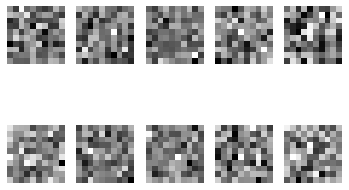

In [34]:
# Visualize generated noise
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((noise[cnt].reshape(10, 10)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

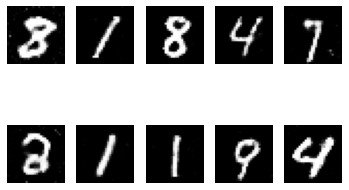

In [35]:
# Visualize generated samples
r, c = 2, 5
fig, axs = plt.subplots(r, c)
cnt = 0
for i in range(r):
    for j in range(c):
        axs[i,j].imshow((generated_images[cnt].reshape(28, 28)), cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
plt.show()

#Part 3: Testing accuracy of generated images on ten samples

In [36]:
# Load mnist classifier and generated images
mnist_classifier = load_model('mnist_classifier.h5')

In [44]:
# ASSIGN CLASSES
labels = [8,1,8,4,7,2,1,1,9,4]
mnist_prediction=mnist_classifier.predict(generated_images)

# Show classifications
print('Predictor classifications')
print(np.argmax(mnist_prediction,axis=1))
print('True labels')
print(labels)

# Convert integer labels to one-hot labels 
labels = keras.utils.np_utils.to_categorical(labels, num_classes=10)

# Evaluate accuracy
loss, acc = mnist_classifier.evaluate(generated_images, labels, verbose=0)
print('Loss is: ')
print(loss)
print('Accuracy')
print(acc*100)

Predictor classifications
[8 1 8 4 7 2 1 1 9 4]
True labels
[8, 1, 8, 4, 7, 2, 1, 1, 9, 4]
Loss is: 
9.536738332371897e-08
Accuracy
100.0


## 3a: Would you say the generator does well in producing images comparable to MNIST datasets? 
Here, our accuracy is 100% so I think we can say that it does a good job. 

3b. How can we better test the accuracy?

We can use a larger number of images to compare and find the accuracy. Here we only tested for 10, so received a 100% score. 